In [1]:
import os
import numpy as np
import math
import random
import datetime

import orekit
vm = orekit.initVM()

ValueError: jvm.dll could not be found

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.attitudes import FrameAlignedProvider
from org.orekit.bodies import CelestialBodyFactory
from org.orekit.bodies import OneAxisEllipsoid
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
from org.orekit.forces.gravity import NewtonianAttraction
from org.orekit.forces.gravity import ThirdBodyAttraction
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.maneuvers import ConstantThrustManeuver
from org.orekit.forces.radiation import IsotropicRadiationSingleCoefficient, IsotropicRadiationClassicalConvention
from org.orekit.forces.radiation import SolarRadiationPressure
from org.orekit.frames import FramesFactory
from org.orekit.orbits import KeplerianOrbit, CartesianOrbit
from org.orekit.orbits import Orbit
from org.orekit.orbits import OrbitType
from org.orekit.orbits import PositionAngleType
from org.orekit.propagation import SpacecraftState
from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
from org.orekit.propagation.numerical import NumericalPropagator
from org.orekit.time import AbsoluteDate
from org.orekit.time import TimeScalesFactory
from org.orekit.utils import Constants
from org.orekit.utils import IERSConventions
from org.orekit.utils import PVCoordinates
from org.orekit.ssa.metrics import ProbabilityOfCollision
from org.hipparchus.linear import RealMatrix
from org.orekit.propagation import StateCovariance
from org.orekit.frames import FramesFactory
from org.hipparchus.linear import MatrixUtils
from org.orekit.ssa.collision.shorttermencounter.probability.twod import Patera2005

from orekit.pyhelpers import datetime_to_absolutedate

In [4]:
random.seed(42)

In [5]:
from orekit.pyhelpers import download_orekit_data_curdir, setup_orekit_curdir
download_orekit_data_curdir()
setup_orekit_curdir()

In [6]:
from org.orekit.frames import FramesFactory
gcrf = FramesFactory.getGCRF()

from org.orekit.time import TimeScalesFactory
utc = TimeScalesFactory.getUTC()

In [7]:
def deg_to_rad(deg: float)-> float:
    return (math.pi * deg) / 180.0

def get_orbital_period(sma: float):
    return 2.0 * np.pi * np.sqrt(np.divide(np.power(sma, 3), Constants.WGS84_EARTH_MU))

def create_propagator(orbit: Orbit, sc_mass: float, sc_area: float, sc_reflection: float, sc_frame: FramesFactory, 
                      ref_time: AbsoluteDate, earth_order: float, earth_degree: float, use_perturbations: bool = True):    
    # create the propagator
    orbit_type = orbit.getType()
    integrator = DormandPrince853IntegratorBuilder(1.0, 1000., 1.0).buildIntegrator(orbit, orbit_type)
    spacecraft_state = SpacecraftState(orbit, sc_mass)

    propagator = NumericalPropagator(integrator)
    propagator.setOrbitType(orbit_type)
    propagator.setInitialState(spacecraft_state)

    # Earth gravity field
    if not use_perturbations:
        point_gravity = NewtonianAttraction(Constants.WGS84_EARTH_MU)
        propagator.addForceModel(point_gravity)
    else:
        earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                                Constants.WGS84_EARTH_FLATTENING,
                                gcrf)
        harmonics_gravity_provider = GravityFieldFactory.getNormalizedProvider(earth_degree, earth_order)
        propagator.addForceModel(
            HolmesFeatherstoneAttractionModel(earth.getBodyFrame(), harmonics_gravity_provider))

        # Sun and Moon attraction
        propagator.addForceModel(ThirdBodyAttraction(CelestialBodyFactory.getSun()))
        propagator.addForceModel(ThirdBodyAttraction(CelestialBodyFactory.getMoon()))

        # Solar radiation pressure
        propagator.addForceModel(
            SolarRadiationPressure(CelestialBodyFactory.getSun(),
                                earth,
                                IsotropicRadiationSingleCoefficient(sc_area,
                                                                    sc_reflection)))

    rotation = FramesFactory.getEME2000().getTransformTo(sc_frame, ref_time).getRotation()
    attitude = FrameAlignedProvider(rotation)
    propagator.setAttitudeProvider(attitude)

    return propagator

def propagate_(propagator, time):
    propag_response_state = propagator.propagate(time)
    return propag_response_state

In [8]:
action = [1.0, -0.5, 1.1]

In [13]:
for i in range(3):
    if abs(action[i]) > 0.0:
        direction = Vector3D(list((1.0 if action[i] > 0 else -1.0) if i == j else 0.0 for j in range(3)))
        force = (1.0 * abs(action[i]))
        print(direction)
        print(force)

{1; 0; 0}
1.0
{0; -1; 0}
0.5
{0; 0; 1}
1.1


In [7]:
# 1. Set the orbit definition parameters for the primary object
# keplerian elements of ISS, without the true anomally (which indictes the position on the orbit)
sma = 6795.e3
ecc = 0.00048
inc = 51.6413  # deg
argp = 21.0174  # deg
raan = 60  # deg

inc_rad = deg_to_rad(inc)
argp_rad = deg_to_rad(argp)
raan_rad = deg_to_rad(raan)

sc_mass = 100.0  # kg
sc_area = 1.0 # m^2
sc_reflection = 2.0 # Perfect reflection - maybe it is not needed to use the solar radiation model

# 2. Randomly select a point on the orbit (by setting the true anomally randomly)
tran = 2.0 * np.pi * random.random()

# define the orbit of the primary object with the parameters obtained in the GCRF ref frame, at the defined ref time
# initial SV
init_sv = np.array([sma, ecc, inc_rad, argp_rad, raan_rad, tran])
ref_sc_frame = gcrf
ref_time = AbsoluteDate(2023, 6, 16, 0, 0, 0.0, TimeScalesFactory.getUTC())

# 3. Create the orbit object of the primary satellite
kep = init_sv.tolist()
primary_orbit_kepl = KeplerianOrbit(kep[0], kep[1], kep[2], kep[3], kep[4], kep[5],
                                    PositionAngleType.MEAN, ref_sc_frame, ref_time, Constants.WGS84_EARTH_MU)
primary_orbit_cart = CartesianOrbit(primary_orbit_kepl)
primary_sc_state = SpacecraftState(primary_orbit_cart, sc_mass)

# 4. Get the position and velocity of the initial state of the primary object
init_primary_pos = np.array(primary_sc_state.getPVCoordinates().getPosition().toArray())
init_primary_vel = np.array(primary_sc_state.getPVCoordinates().getVelocity().toArray())

# 5. Get the position and velocity of the initial state of the secondary object
# 5.1 Position - Get the position difference between the secondary and primary objects sampled from a normal distribution, 
# mean 0, std 1. Multiply it by 10, so the obtained value is in the order of 10 and add it to each component of the pos vector
# of the primary.
# 5.2 Velocity - Get the velocity difference between the secondary and primary objects sampled from a normal distribution, 
# mean 0, std 1. Multiply it by 10, so the obtained value is in the order of 10 and add it to each component of the 
# inverse of the vel vector of the primary. The reason for choosing the inverse is to have a head-on-collision.
init_secondary_pos = 10.0 * np.random.standard_normal(3) + init_primary_pos
init_secondary_vel = 10.0 * np.random.standard_normal(3) + (-1.0 * init_primary_vel)

# 6. Create the orbit object of the secondary sat
sec_pos_vec, sec_vel_vec = Vector3D(init_secondary_pos.tolist()), Vector3D(init_secondary_vel.tolist())
sec_pv_coord = PVCoordinates(sec_pos_vec, sec_vel_vec)
secondary_orbit_cart = CartesianOrbit(sec_pv_coord, gcrf, ref_time, Constants.WGS84_EARTH_MU)
secondary_sc_state = SpacecraftState(secondary_orbit_cart, 10.0)

In [8]:
init_primary_pos

array([ 2360511.39347905, -3896221.51589487, -5044587.44642333])

In [9]:
init_secondary_pos

array([ 2360496.11832898, -3896220.04870868, -5044598.07164654])

In [10]:
np.linalg.norm(init_primary_pos - init_secondary_pos)

18.664892525101994

In [11]:
primary_propagator = create_propagator(orbit=primary_orbit_cart, sc_mass=sc_mass, sc_area=sc_area, sc_reflection=sc_reflection,
                                       sc_frame=gcrf, ref_time=ref_time, earth_order=16, earth_degree=16)
secondary_propagator = create_propagator(orbit=secondary_orbit_cart, sc_mass=10.0, sc_area=sc_area, sc_reflection=sc_reflection,
                                         sc_frame=gcrf, ref_time=ref_time, earth_order=16, earth_degree=16)

In [12]:
print("Start time: ", datetime.datetime.now())

### Identify the TCA and the minimum distance between objects

# get the orbital period and the time discretization around the reference time (which should be close to the TCA)
orb_period = primary_orbit_cart.getKeplerianPeriod()
ref_period = orb_period / 8.0 # an eith of the orbital period
step_duration = 5.0  # seconds

num_points = int(2 * ref_period / step_duration)
time_discretisation_positive = np.linspace(start=0, stop=ref_period, num=num_points//2)
time_discretisation_neggative = np.linspace(start=-ref_period, stop=-step_duration, num=num_points//2)
time_discretisation = np.append(time_discretisation_neggative, time_discretisation_positive)

primary_orbital_positions = []
secondary_orbital_positions = []

# get the positions of each satellite at the required times
for time_step in time_discretisation:
    current_time = ref_time.shiftedBy(float(time_step))
    primary_state = propagate_(propagator=primary_propagator, time=current_time)
    secondary_state = propagate_(propagator=secondary_propagator, time=current_time)

    primary_orbital_positions.append(np.array(primary_state.getPosition().toArray()))
    secondary_orbital_positions.append(np.array(secondary_state.getPosition().toArray()))

# compute the difference between the 2 satellites at each time step
differences = []
for idx, orb_pos_primary in enumerate(primary_orbital_positions):
    differences.append(np.linalg.norm(orb_pos_primary - secondary_orbital_positions[idx]))

# find the minimum distance and the TCA
min_distance_between_objects = min(differences)
min_time_idx = differences.index(min_distance_between_objects)

tca = ref_time.shiftedBy(float(time_discretisation[min_time_idx]))

print(f"Minimum Distance: {min_distance_between_objects}")
print(f"Primary Position: {primary_orbital_positions[min_time_idx]}")
print(f"Secondary Position: {secondary_orbital_positions[min_time_idx]}")
print(f"Redundant min distance: {np.linalg.norm(primary_orbital_positions[min_time_idx] - secondary_orbital_positions[min_time_idx])}")
print(f"TCA: {tca}")
print(f"Ref Time: {ref_time}")

print("Stop time: ", datetime.datetime.now())

Start time:  2024-04-06 18:57:26.294936
Minimum Distance: 18.703228434306677
Primary Position: [ 2360511.40138689 -3896221.25306799 -5044587.25701183]
Secondary Position: [ 2360496.25543905 -3896219.92907732 -5044598.15004017]
Redundant min distance: 18.703228434306677
TCA: 2023-06-16T00:00:00.000Z
Ref Time: 2023-06-16T00:00:00.000Z
Stop time:  2024-04-06 18:57:28.031576


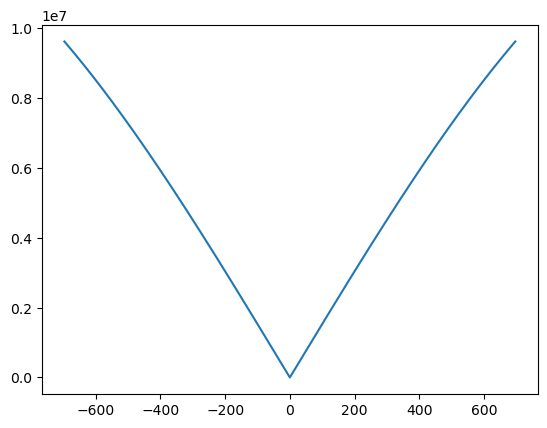

In [13]:
plt.plot(time_discretisation, differences)